In [1]:
library("pacman")
# Load all required libraries. Suppresses all messages AND warnings.
pacman::p_load("xcms", "RANN", "modeest", "CAMERA", "tools", "tidyverse",
               "parallel", "pander", "magrittr",  "scales", "RColorBrewer",
               "dplyr", "ggpubr", "dsm", "gtools", "plotly", 
               "htmltools", "berryFunctions", "fda")
# Ommitted: MSeasy, plyr

# 1. Input Params

Various input parameters, including:
* working directory
* instrument parameters (`rtStart`, `rtEnd`...)

In [2]:
pathToProject <- "/Users/don/Documents/MStractor-refactored"
setwd(pathToProject)

# path to reference file
ref.fn <- paste0(pathToProject, "/data/pooled_R1.mzXML")

fn.ls <- dir(paste0(pathToProject, "/data/"), full.names=TRUE, pattern="\\.mzXML", recursive=TRUE)
print(fn.ls)

#QCdataAll <- TRUE # IF TRUE, EICs for every molecular feature will be plotted
CPUs <- "max"      # Concurrent CPU threads to run. "max" to autodetect
updatePackages <- "FALSE" # If TRUE, all packages will be automatically updated

# "Acquisition Parameters" - Parameters relating to the acquisition -------
# ========== Chromatography parameters ==========
# Tuned to faahKO data (Agilent 1100 400 bar HPLC)
rtStart <- 1    # Start region of interest (in seconds)
rtEnd <- "max"  # End region of interest (in seconds). "max" for RT full range
FWHM_min <- 10  # FWHM in seconds of narrowest peak (10)
FWHM_max <- 90  # FWHM in seconds of broadest peak (40)
rtDelta <- 3705-3673   # Max observed difference in retention time (s) across all
# samples (peak apex to peak apex delta).

# ========== MS parameters ==========
# Tuned for faahKO data (Agilent MSD SL ion trap)
mzPol <- "negative" # Set to "positive" or "negative" ion mode
mzStart <- 100  # Start of m/z region of interest
mzEnd <- 1650   # End of m/z region of interest
mzErrAbs <- 0.01 # Max m/z delta expected for the same feature across all samples
mzZmax <- 3     # Max charge state expected
EICsMax <- 30   # Max number of chrom. peaks expected for a single EIC
sens <- 1      # Factor (between 0 and 1) for peak extraction sensitivity
# Impacts peak picking thresholds, RAM & CPU utilisation.
# Start with ~0.5.
fileType <- "mzXML" # MS data file type e.g. "mzData", "mzML", "mzXML", "CDF"

# Init timer
runtimeStart <- Sys.time()
runtimeStart

[1] "/Users/don/Documents/MStractor-refactored/data//pooled_R1.mzXML"    
[2] "/Users/don/Documents/MStractor-refactored/data//pooled_R2.mzXML"    
[3] "/Users/don/Documents/MStractor-refactored/data//Pooled_R3.mzXML"    
[4] "/Users/don/Documents/MStractor-refactored/data//Treatment1_R1.mzXML"
[5] "/Users/don/Documents/MStractor-refactored/data//Treatment1_R2.mzXML"
[6] "/Users/don/Documents/MStractor-refactored/data//Treatment1_R3.mzXML"
[7] "/Users/don/Documents/MStractor-refactored/data//Treatment2_R1.mzXML"
[8] "/Users/don/Documents/MStractor-refactored/data//Treatment2_R2.mzXML"
[9] "/Users/don/Documents/MStractor-refactored/data//Treatment2_R3.mzXML"


[1] "2019-07-30 16:22:20 AEST"

# 2. Check out the Reference

For QC purposes.

Create profile matrix with method 'bin' and step 0.04 ... OK
Warning message in dir.create("./QC"):
“'./QC' already exists”

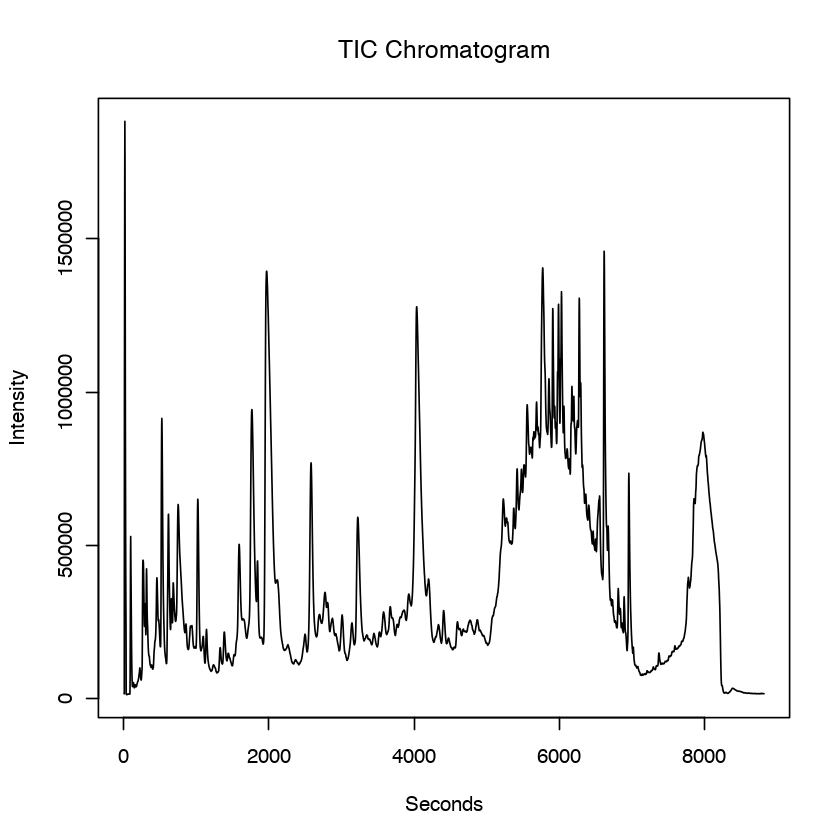

In [3]:
# Load a reference file & define the scan range
# Set mz step size, profStep, for seeking new EIC traces
refRaw <- xcmsRaw(ref.fn, profstep= mzErrAbs*4, includeMSn= FALSE, mslevel= NULL,
                  scanrange= NULL)

# Plot TIC of reference sample
# create a new dir, called QC, if one doesn't already exist.

dir.create("./QC")
#graphics.off
#png("./QC/Ref_TIC.png", width = 1024, height = 768, units = "px")
plotTIC(refRaw, ident= FALSE, msident= FALSE)
#dev.off()

In [4]:
# Determine scan range
scanStart <- head(which(refRaw@scantime > rtStart & refRaw@scantime < rtEnd),
                  n= 1)

if (identical(rtEnd, "max")) {
  scanEnd <- max(refRaw@scanindex)
  rtEnd <- refRaw@scantime[which(refRaw@scanindex == scanEnd)]
} else {
  scanEnd <- tail(which(refRaw@scantime > rtStart & refRaw@scantime < rtEnd),
                  n= 1)
}

# Set peak picking parameters

pwMin <- FWHM_min*1.3
pwMax <- pwMin*1.3
mzErrPpmMin <- mzErrAbs/2/mzEnd*1000000
mzErrPpmMax <- mzErrAbs/2/mzStart*1000000
mzErrPpmMean <- mean(c(mzErrPpmMin,mzErrPpmMax))
mzdiff <- mzErrAbs/5
intThresh <- as.integer(quantile(refRaw@env$intensity,1-sens)*10)
snThresh <- 30/sens
integ <- 1
fitGauss <- FALSE
sleep <- 0

# Plot picked peaks to file
#sleep <- 0.001
#png(file.path("./QC/Pks/%003d.png"), h=768, w=1024)
refPks <- findPeaks(refRaw, method= 'centWave', ppm= mzErrPpmMin*2,
                    peakwidth= c(pwMin, pwMax), snthresh= snThresh,
                    prefilter= c(5,intThresh), mzCenterFun= "mean",
                    integrate= integ, mzdiff= mzdiff, verbose.columns= TRUE,
                    fitgauss= fitGauss, noise= intThresh, sleep= sleep)

png("./QC/Ref_EICs_100.png", width = 1024, height = 768, units = "px")
plotPeaks(refRaw, refPks,  c(10,10), width = FWHM_min*10)


Detecting mass traces at 6.06060606060606 ppm ... OK
Detecting chromatographic peaks in 8343 regions of interest ... OK: 1145 found.


# 3. Start Processing all Files

Start batch processing of all files.

In [5]:
# load metadata as tibble
tbl.m <- read_csv("data/metadata.csv")

# Get group colours
group.colours <- brewer.pal(3, "Set1")
names(group.colours) <- unique(unlist(as.vector(tbl.m["sample_group"])))

# Allocate colour to each sample, coloured by group
group.vec <- as.vector(unlist(tbl.m[,"sample_group"]))
sample.colours.ls <- vector(mode="character", length=nrow(tbl.m))

for (i in 1:length(group.vec)) {
    colour <- unlist(as.vector(group.colours[group.vec[i]]))
    sample.colours.ls[i] <- colour
}

# read all data files
raw_data <- readMSData(files = fn.ls, pdata = new("NAnnotatedDataFrame", tbl.m), mode = "onDisk")

Parsed with column specification:
cols(
  sample_name = col_character(),
  sample_group = col_character()
)


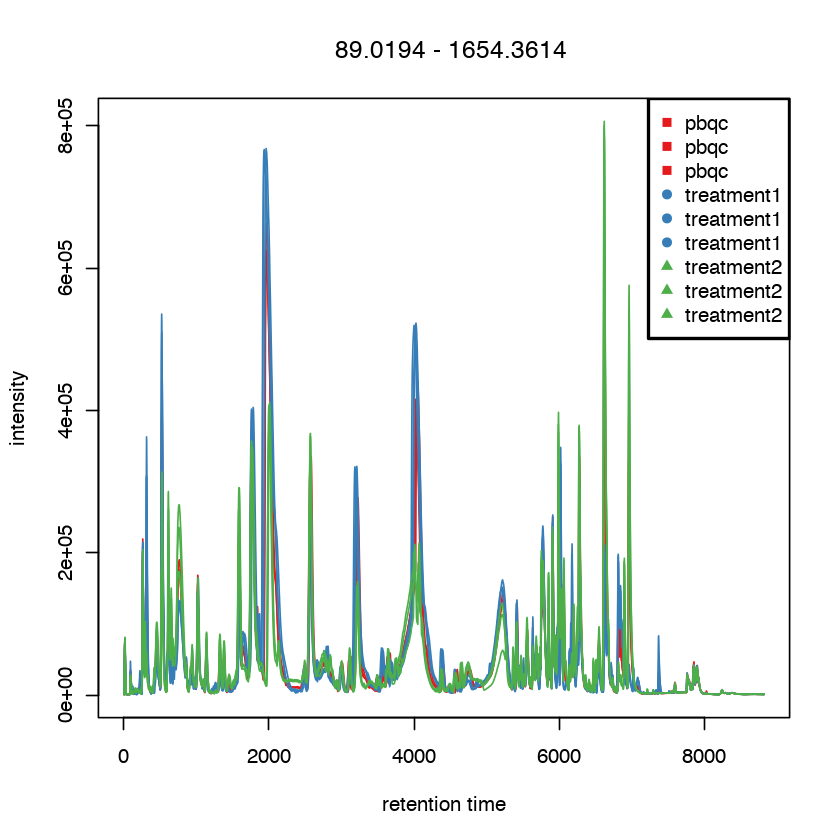

In [6]:
# with the new script first an XCMSnEXP object is created , then it is necessary to translate that in an XCMS object and check the sampclass
# Using Centwave
# N.B. Whilst Centwave does not perform binning (it uses the raw data directly)
# downstream methods such as getEIC will use the step paramter

## Get the base peak chromatograms. This reads data from the files.
#png("./overlaid_BPSchromatograms.png", width = 1024, height = 768, units = "px")
bpis <- chromatogram(raw_data, aggregationFun = "max")
plot(bpis, col = sample.colours.ls)
legend("topright", box.lwd = 2, legend=c(tbl.m$sample_group), pch=c(15, 15,15, 16, 16,16,17,17,17),
col = sample.colours.ls, xpd=FALSE)
#dev.off()

### 3a. findChromPeaks

In [7]:
##peak detection and creation of an XCMSnEXP object.
cwp <- CentWaveParam(peakwidth = c(30, 90), 
                     snthresh = 30/sens, 
                     prefilter= c(3,intThresh), 
                     integrate = integ, 
                     fitgauss = FALSE, 
                     noise = 0, 
                     verboseColumns = FALSE, 
                     firstBaselineCheck = TRUE, 
                     ppm=30, 
                     mzCenterFun= "wMean")

xdata <- findChromPeaks(raw_data, param = cwp)
spn <- xdata@phenoData$sample_name

R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send

In [8]:
### peak det param are the same used in the old script
xset <- as(xdata, "xcmsSet")# turns the XCMSnExp object into a xcms set object 

sampclass(xset)<-factor((xdata$sample_group))
sampnames(xset)<-spn

xset # To checkout slots use slotNames(xset); ls(xset@groups)

Note: you might want to set/adjust the 'sampclass' of the returned xcmSet object before proceeding with the analysis.
Warning message:
“Setting row names on a tibble is deprecated.”

An "xcmsSet" object with 9 samples

Time range: 16.2-8820.7 seconds (0.3-147 minutes)
Mass range: 96.9573-1565.3693 m/z
Peaks: 42793 (about 4755 per sample)
Peak Groups: 0 
Sample classes: pbqc, treatment1, treatment2 

Feature detection:
 o Peak picking performed on MS1.
 o Scan range limited to  1 - 4400 
Profile settings: method = bin
                  step = 0.1

Memory usage: 12.3 MB

In [9]:
# Determine the size of smallest class ---------------
class.size.tbl <- tbl.m %>% group_by(sample_group) %>% tally()
min.class.size <- min(class.size.tbl["n"])


mzWid <- mzErrAbs
bw <- mzWid/2
minsamp <- ceiling(min.class.size)-1

### 3b. Peak Grouping with `xcms::group`

* Uses the grouping method from `MZmine`, which doesn't have `minfrac` or `minsamp`. 
* Mordernized version: use `groupChromPeaks()`?

In [10]:
# group-methods {xcms}
xset <- group(xset, 
              method = "nearest", 
              mzVsRTbalance = 10, 
              mzCheck = mzErrAbs,
              rtCheck = rtDelta, 
              kNN = 10)

Processing sample number 8 ... OK
Processing sample number 7 ... OK
Processing sample number 3 ... OK
Processing sample number 9 ... OK
Processing sample number 6 ... OK
Processing sample number 2 ... OK
Processing sample number 4 ... OK
Processing sample number 5 ... OK


In [11]:
# ========== Some function definitions ==========
# Function: TICsOverlaid
getTIC <- function(file,rtcor=NULL) {
  object <- xcmsRaw(file)
  cbind(if (is.null(rtcor)) object@scantime else rtcor,
        rawEIC(object,mzrange=range(object@env$mz))$intensity)
}

# Overlay TIC from all files in current folder or from xcmsSet, create PNG
getTICs <- function(xcmsSet=NULL,files=NULL, pngName="TICs.png",
                    rt=c("raw","corrected")) {
  if (is.null(xcmsSet)) {
    filepattern <- c("[Cc][Dd][Ff]", "[Nn][Cc]", "([Mm][Zz])?[Xx][Mm][Ll]",
                     "[Mm][Zz][Dd][Aa][Tt][Aa]", "[Mm][Zz][Mm][Ll]")
    filepattern <- paste(paste("\\.", filepattern, "$", sep = ""),
                         collapse = "|")
    if (is.null(files))
      files <- getwd()
    info <- file.info(files)
    listed <- list.files(files[info$isdir], pattern = filepattern,
                         recursive = TRUE, full.names = TRUE)
    files <- c(files[!info$isdir], listed)
  }
  else {
    files <- filepaths(xcmsSet)
  }

  N <- length(files)
  TIC <- vector("list",N)

  for (i in 1:N) {
    cat(files[i],"\n")
    if (!is.null(xcmsSet) && rt == "corrected")
      rtcor <- xcmsSet@rt$corrected[[i]] else
        rtcor <- NULL
    TIC[[i]] <- getTIC(files[i],rtcor=rtcor)
  }

  png(pngName,h=768, w=1024)
  #cols <- rainbow(N)
  cols <- as.integer(sampclass(xcmsSet)) + 1
  lty = 1:N
  pch = 1:N
  xlim = range(sapply(TIC, function(x) range(x[,1])))
  ylim = range(sapply(TIC, function(x) range(x[,2])))
  plot(0, 0, type="n", xlim = xlim, ylim = ylim,
       main = "Total Ion Chromatograms", xlab = "Retention Time (s)",
       ylab = "TIC")
  for (i in 1:N) {
    tic <- TIC[[i]]
    points(tic[,1], tic[,2], col = cols[i], pch = pch[i], type="l")
  }
  legend("topright",paste(basename(files)), col = cols, lty = lty, pch = pch)
  dev.off()

  invisible(TIC)
}

In [12]:
# QC Plots ----------------------------------------------------------------
# Plot TICs as PNG
getTICs(xcmsSet = xset, pngName= "./QC/TICs_Raw.png", rt= "raw")

# if (QCdataAll == TRUE ){
#   QCplots <- c("mzdevhist", "rtdevhist", "mzdevmass", "mzdevtime",
#                "mzdevsample", "rtdevsample")
#
#   for (i in QCplots){
#     png(filename= paste("./QC/","QCplot_","align0_", i, ".png", sep= ""),
#         w=1280, h=1024)
#     plotQC(xset, what= i)
#     dev.off()
#   }

# Get EICs
xset_grps <- xset@groups

eicRange <- 2*mean(c(FWHM_min,FWHM_max))
eicsRaw <- getEIC(xset, mzrange=xset_grps, rtrange= eicRange ,
                  groupidx = 1:nrow(xset_grps), rt= "raw")

# Plot as individual PNGs
dir.create("./QC/EICs_Raw/")
do.call(file.remove,list(list.files("./QC/EICs_Raw", full.names= TRUE)))
graphics.off()
png(file.path("./QC/EICs_Raw/%003d.png"), h=768, w=1024)
plot(eicsRaw, xset)
dev.off()

/Users/don/Documents/MStractor-refactored/data/pooled_R1.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/pooled_R2.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Pooled_R3.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment1_R1.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment1_R2.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment1_R3.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment2_R1.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment2_R2.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment2_R3.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK
Provided scanrange was adjusted to 1 - 4399
Create profile matrix with method 'bin' and step 0.1 ... OK
Create profile matrix with method 'bin' and step 0.1 ... OK


logical(0)

null device 
          1

In [13]:
# Export matrix prior to RT Alignment -------------------------------------
xsTable <- peakTable(xset, filebase= "./QC/xsTable", method= "medret",
                     value= "maxo")

write.table(xsTable[with(xsTable, order(rt, mz)), ],
            file= "./QC/xsTable.tsv", sep= "\t", quote= FALSE, col.names= NA)

### 3c. RT Alignment

In [14]:
# "RT Alignment" - Aligns the extracted molecular features ----------------
align_ref <- match(basename(ref.fn),basename(fn.ls[]))

png(filename= "./QC/rtAlignLoess.png", w=1280, h=1024)
xsAlign <- retcor(xset, method= "loess", missing= 3, extra= 0, span= 0.3,
                  family= "gaussian", plottype= "deviation")
dev.off()
#xsAlign

xsAlign <- group(
  xsAlign, method= "nearest", mzVsRTbalance= 10, mzCheck= mzErrAbs,
  rtCheck= rtDelta, kNN=10)
#xsAlign

# Plot TICs
getTICs(xcmsSet= xsAlign, pngName= "./QC/TICs_Aligned.png", rt= "corrected")

# Retrieve missing data
xsFilled <- fillPeaks(xsAlign, method="chrom", nSlaves=CPUs)

# Plot EICs ---------------------------------------------------------------
xsFilledGrps <- xsFilled@groups
eicsFilled <- getEIC(xsFilled, mzrange= xsFilledGrps, rtrange= FWHM_max*2,
                     groupidx= 1:nrow(xsFilledGrps), rt= "corrected")

dir.create("./QC/EICs_Aligned/")
do.call(file.remove,list(list.files("./QC/EICs_Aligned", full.names= TRUE)))
graphics.off()
png(file.path("./QC/EICs_Aligned/%003d.png"), h=768, w=1024)

plot(eicsFilled, xsFilled)
dev.off()

Performing retention time correction using 2833 peak groups.


pdf 
  2

An "xcmsSet" object with 9 samples

Time range: 16.1-8825 seconds (0.3-147.1 minutes)
Mass range: 96.9573-1565.3693 m/z
Peaks: 42793 (about 4755 per sample)
Peak Groups: 0 
Sample classes: pbqc, treatment1, treatment2 

Feature detection:
 o Peak picking performed on MS1.
 o Scan range limited to  1 - 4400 
Profile settings: method = bin
                  step = 0.1

Memory usage: 12.3 MB

Processing sample number 8 ... OK
Processing sample number 7 ... OK
Processing sample number 3 ... OK
Processing sample number 9 ... OK
Processing sample number 6 ... OK
Processing sample number 2 ... OK
Processing sample number 4 ... OK
Processing sample number 5 ... OK


An "xcmsSet" object with 9 samples

Time range: 16.1-8825 seconds (0.3-147.1 minutes)
Mass range: 96.9573-1565.3693 m/z
Peaks: 42793 (about 4755 per sample)
Peak Groups: 12360 
Sample classes: pbqc, treatment1, treatment2 

Feature detection:
 o Peak picking performed on MS1.
 o Scan range limited to  1 - 4400 
Profile settings: method = bin
                  step = 0.1

Memory usage: 14.3 MB

/Users/don/Documents/MStractor-refactored/data/pooled_R1.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/pooled_R2.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Pooled_R3.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment1_R1.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment1_R2.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment1_R3.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment2_R1.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment2_R2.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK


/Users/don/Documents/MStractor-refactored/data/Treatment2_R3.mzXML 


Create profile matrix with method 'bin' and step 1 ... OK
Use of argument 'nSlaves' is deprecated, please use 'BPPARAM' instead.
/Users/don/Documents/MStractor-refactored/data/pooled_R1.mzXML 
method:  bin 
step:  0.1 
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
/Users/don/Documents/MStractor-refactored/data/pooled_R2.mzXML 
method:  bin 
step:  0.1 
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system 

logical(0)

null device 
          1

# 4. Annotation with `CAMERA`

From the docs, two questions that need to be addressed:
1. which peaks occur from the same molecule?
2. Compute the exact mass and annotate the ion species.

The CAMERA annotation workflow contains the primary functions:
1. peak grouping after retention time (`groupFWHM`)
2. peak group verification with peak-shape correlation (`groupCorr`)

In [ ]:
# "Reconstruct Spectra" - Construct deconvoluted spectra ------------------
ppm <- mzErrPpmMean/2
mzabs <- mzErrAbs
minfrac <- min.class.size/length(fn.ls)
xs <- xsFilled # Choose an xcmxSet object

# Using CAMERA:
xs_an <- xsAnnotate(xs, polarity = mzPol, nSlaves = 1) # nSlaves>1 is broken

# do peak grouping after retention time
xs_an <- groupFWHM(xs_an, sigma = 6, perfwhm = 1, intval = "maxo")

xs_an <- findIsotopes(xs_an, maxcharge=mzZmax, maxiso=4, ppm= ppm,
                      mzabs= mzabs, intval="maxo", minfrac=minfrac,
                      filter= TRUE)

# peak group verification with peak shape correlation
xs_an <- groupCorr(xs_an, cor_eic_th= 0.7, pval=0.1,
                   graphMethod="hcs", calcIso= TRUE, calcCiS = TRUE,
                   calcCaS= TRUE, cor_exp_th= 0.7)

# Not appropriate for EI spectra
PksAn <- getPeaklist(xs_an, intval="maxo")
print(paste0(nrow(PksAn), " mz@rt features detected"))

write.table(PksAn, file="./QC/Pks_An.csv", sep= ",", col.names = NA, row.names = TRUE)

Start grouping after retention time.
Created 423 pseudospectra.


In [ ]:
# "Export Matrix" - Filter peaks and export basepeak matrix ---------------

# 1. Filter lone groups.
# Count number of entities for each factor
pcgroups <- table(PksAn$pcgroup)
min_ions <- 2
PksAnFilt <- droplevels(PksAn[PksAn$pcgroup %in% names(pcgroups)
                              [pcgroups >= min_ions],,drop=FALSE])

# 2. Optionally, select signals that are part of an isotope group
#PksAnFilt <- PksAnFilt[PksAnFilt$isotopes != "", ]
#PksAnFilt <- PksAn[PksAn$isotopes != "", ]

# 3. Determine median signal intensity
sNames <- sampnames(xs)
RespMed <- apply(PksAnFilt[c(sNames)], 1, median, na.rm= TRUE)

RespMed <- apply(PksAnFilt[c(11:19)], 1, median, na.rm= TRUE)
PksAnFilt <-cbind(PksAnFilt, RespMed)

# 4. Keep only the most intense signal from each pcgroup
# Other values may be preferred
#RespMed <- PksAnFilt$RespMed
# May be required if factors aren't recognised
# PeakList$pcgroup <- as.factor(PeakList$pcgroup)
BasePks <- PksAnFilt[ RespMed == ave(RespMed, PksAnFilt$pcgroup,
                                     FUN= function(RespMed) max(RespMed))
                      , ]
# BasePks[order(as.numeric(BasePks$pcgroup)),]
write.table(BasePks[with(BasePks, order(rt, mz)), ],
            file=paste("Pks_BPs", "csv", sep="."), sep= ",",
            col.names= NA, row.names= TRUE)

In [ ]:
# Fetch basePeak EICs ---------------------------------------------------------------
BP_EICs <- paste(sprintf("%03d",as.numeric(rownames(BasePks))),"png", sep= ".")

dir.create("./EICs_BasePeaks/")
suppressWarnings(do.call(file.remove,list(list.files("./EICs_BasePeaks/", full.names= TRUE))))
for (i in 1:length(BP_EICs)){
  sourceF <- paste("./QC/EICs_Aligned/", BP_EICs[i], sep= "")
  destF <- paste("./EICs_BasePeaks/", BP_EICs[i], sep= "")
  file.copy(from= sourceF, to= destF, overwrite= FALSE)
}

dir.create("./EICs_BasePeaks_Curated/")
suppressWarnings(do.call(file.remove,list(list.files("./EICs_BasePeaks_Curated/", full.names= TRUE))))
for (i in 1:length(BP_EICs)){
  sourceF <- paste("./QC/EICs_Aligned/", BP_EICs[i], sep= "")
  destF <- paste("./EICs_BasePeaks_Curated/", BP_EICs[i], sep= "")
  file.copy(from= sourceF, to= destF, overwrite= TRUE)
}

In [ ]:
# Stop watch --------------------------------------------------------------
sessionInfo <- sessionInfo()

now <- Sys.time()
time <- unclass(as.POSIXlt(now))
timeStamp <-paste(time$year,time$mon, time$mday, time$hour, time$min, sep="_")
#imageName <- paste(timeStamp, "RData", sep= ".")
#save.image(imageName)
#historyName <- paste(timeStamp,"RHistory", sep= ".")
#savehistory(historyName)

runtimeEnd <- Sys.time()
runtime <- runtimeEnd - runtimeStart
runtime

gc()


In [ ]:
# Peak Curation -----------------------------------------------------------

files <- dir("./EICs_BasePeaks_Curated/")
pks <- basename(file_path_sans_ext(dir("./EICs_BasePeaks_Curated/")))
BasePksCur <- BasePks[sprintf("%03d",as.numeric(rownames(BasePks))) %in% pks,]
write.table(BasePksCur[with(BasePksCur, order(rt,mz)), ],
            file= paste("PksBPsCurated", "tsv", sep="."),
            sep= "\t", col.names= NA, row.names= TRUE)


##AUTOMATIC MEDIAN NORMALISATION

colnum<-ncol(BasePksCur)
BasePksCur$id <- rownames(BasePksCur)
idcolnum<-ncol(BasePksCur)

BasePksCur<-BasePksCur[c(idcolnum,1:colnum)]

BasePksCur<-BasePksCur[with(BasePksCur, order(rt,mz)), ]
BasePksCur$rt<-BasePksCur$rt/60
AIN<-BasePksCur[,c(1,2,5)]
write.table(AIN,file= paste("AIN", "tsv", sep="."),
            sep= "\t", col.names= TRUE, row.names= FALSE)

sub1<-colnames(BasePksCur)	
replicates<-which(sub1%in%Files)
BasePksCurSel<-subset(BasePksCur, select=replicates)
SimpMatrix<-merge(AIN, BasePksCurSel, by="row.names");SimpMatrix[,1]<-NULL

write.table(SimpMatrix[with(SimpMatrix, order(rt,mz)), ],
            file= paste("Simp_Curated", "tsv", sep="."),
            sep= "\t", col.names= NA, row.names= TRUE)  #### matrix with simplified inputs


Median<-apply(BasePksCurSel, 2, FUN = median, na.rm=TRUE)
norm<-sweep(BasePksCurSel, 2, Median, `/`)
NormalizedMatrix<-merge(AIN, norm, by="row.names");NormalizedMatrix[,1]<-NULL
t<-format(round(NormalizedMatrix[,2:ncol(NormalizedMatrix)], 4), nsmall = 4)
NormalizedMatrix[,2:ncol(NormalizedMatrix)]<-t	

NormalizedMatrix[,3]<-as.numeric(NormalizedMatrix[,3])
NormalizedMatrix[,2]<-as.numeric(NormalizedMatrix[,2])	

fix(NormalizedMatrix) # check all the columns but id are numeric

write.table(NormalizedMatrix[with(NormalizedMatrix, order(rt,mz)), ],
            file= paste("NormalizedMatrix", "tsv", sep="."),
            sep= "\t", col.names= NA, row.names= TRUE)  #### matrix with simplified inputs


# 5. Descriptive Statistics

In [ ]:
#DESCRIPTIVE STATISTICS

#identify data classes
classes<-dir("./MSfiles/", full.names=FALSE, all.files=FALSE)

set<-rep(list(vector()), length(classes) )
for (i in 1:length(classes)){
 categories <- which(grepl(classes[i],Files))
 set[[i]]<-categories
}

Files[set[[1]]]

options("scipen"=999) # disables scientific notation

descriptive_stats<-rep(list(matrix()), length(classes))

#####for loop responsible for running Descriptive_statistics 
for (i in 1:length(set)){
    selection <- as.matrix(subset((NormalizedMatrix), select=Files[set[[i]]]))
    stdev<-as.matrix(apply(selection, 1, sd)); colnames(stdev)<-paste('St.Dev.',classes[i])
    average<-as.matrix(apply(selection, 1, mean)); colnames(average)<-paste('Average',classes[i])  
    cv<-as.matrix((stdev/average)*100); colnames(cv)<-paste('CV%',classes[i])
    statsb<-as.matrix(cbind(selection, (cbind(average, stdev, cv))))
    class_stats<-as.matrix(format(round(statsb, 2), nsmall = 2))
    class(class_stats)<-'numeric'
    class_statsdf<-as.data.frame(class_stats)
    descriptive_stats[[i]]<-class_statsdf
}
 ###the average stdev and rsd values are calculated with 5 decimal figures. When the descriptive statistic is printed values are reported with to 2 decimal figures

# Print descriptive statistics results

for (i in 1:length(descriptive_stats)){
  write.table(descriptive_stats[[i]], paste("./","Descriptive_Stats_func", classes[[i]], (".tsv")),sep=" \t", row.names=TRUE) 
}